# Example of catalogue creation using STRAWBERRY

This notebook presents how one can use STRAWBERRY to create a catalogue of dark matter haloes. This example is designed to work with simulations run using <a href="https://wwwmpa.mpa-garching.mpg.de/gadget4/">Gadget-4</a>. To run this example, a low resolution snapshot and a SubFind catalogue are provided in the `example_data` directory. Note that we also provide the Config and parameter files that were used to generate these data. 

Disclaimer: due to file size limitation, the snapshot has been manually split into 4 files. While in this context they can be used just as if they were generated directly in this state, we inform the user that the headers show some discrepancies in attributes not used by the code. 
Furthermore, this notebook uses multiprocessing to analyse several haloes simultaneously. To achieve this, we load the snapshot as shared memory NumPy arrays. From experience, these arrays can sometimes cause issues when the code does not exit properly, most notably staying loaded in memory after the Python kernel has unexpectedly died. While precautions have been taken to make sure the memory is freed upon exit, we cannot guaranty this will happen 100% of the time, and as such we advise caution when using the methodology presented below. Your RAM, your responsibility.

The example simulation snapshot we have provided uses the cosmological parameters of the Illustris TNG300 simulation, namely, $\Omega_{\rm m,0} = 0.3089$, $\Omega_{\Lambda,0} = 0.6911$, $\Omega_{\rm b,0} = 0.045$, $n_{\rm s} = 0.9667$, and $h = 0.6774$. It represents a comoving periodic box of side length $L_{\rm box} = 205 h^{-1}{\rm Mpc}$ sampled by $N=156^3$ particles, at redshift $z=0$. The initial condition were generated at $z=99$ using the built-in NGenIC initial condition generator and using the Eisenstein & Hu (1996) approximation to the linear matter power spectrum.

Data needed to run STRAWBERRY:

Particles
<ul>
    <li> IDs
    <li> Positions
    <li> Velocities
    <li> Accelerations
    <li> Gravitational Potential
</ul>

FoF Groups
<ul>
    <li> Group positions
    <li> Access to group particles (Gadget-4 does this with offsets and lengths)
</ul>

The neighbours will be generated by the code below but can also be provided separately. Note that STRAWBERRY expects 64-bit floats and integers as inputs, so don't forget to convert simulation outputs to double precision.

Additional dependencies:
to run this notebook you'll need to install three additional python packages: `tqdm`, `h5py`, and `hilbertcurve`. These are available through PyPI.

In [1]:
import sys
import signal
import atexit
import numpy as np
import logging
logger = logging.getLogger(__name__)

import h5py
import os
import time

import importlib as imp

from scipy.spatial import cKDTree

from tqdm import tqdm

import strawberry_cython as strawberry

from multiprocessing import shared_memory, Queue, Process
from hilbertcurve.hilbertcurve import HilbertCurve

# Setup and reading header and FoF groups

We start by declaring some variables.

In [2]:
 # Number of particles per dimension
Npart = 156

# Snapshot number
snapshot = 49 

# The vaule of of the large scale delta tilde parameter. 
# Other 'physical' values can be computed using the ParticleAssigner method get_delta_th
# Tip: You can declare a ParticleAssigner with small arrays and the correct cosmological parameters to use this method.
d_th = 4.55165 

# The number of neighbours to be assigned to each particle
N_ngb = 10

# The comoving boxsize
Lbox = 205.0

# The number of processes to be used at run time.
n_proc = 4

# Comoving radial bins used for profiles
r_bins = np.geomspace(1e-2,4,50)

# Suffix used for catalogue fies
threshold = f'custom-d{d_th:.3}'

start_full = time.time()

# Reading simulation (More precisely prior halo catalogue to analyse)
print("reading sim...", flush = True)

# Simulation file paths
basedir, t = f"./example_data/", snapshot
snapout = basedir + f"outputs/snapdir_{t:03}/snapshot_{t:03}.hdf5"
fofout = basedir + f"outputs/fof_subhalo_tab_{t:03}.hdf5"

# Output path
output_dir = basedir + 'strawberry_haloes/'

if not os.path.isdir(output_dir):
    os.makedirs(output_dir) 

# Sentinel format: (status, payload)
# status: "OK" or "ERR"
# payload: result or error message
# These are used to track the status of the multiple processes we'll be launching
SENTINEL = ("DONE", None)

# Read FoF catalogue and snapshot header
fof = {}
header = {}

# Note to self: make it adapt to multiple fof files
with h5py.File(fofout, 'r') as f:
    fof["halo_len"] = f["Group/GroupLen"][:]
    fof["halo_mfof"] = f["Group/GroupMass"][:]
    fof["halo_pos"] = f["Group/GroupPos"][:]
    fof["halo_vel"] = f["Group/GroupVel"][:]
    group_len = np.uint64(f['Group/GroupLenType'][:]).T[1]
    group_offsets = np.uint64(f['Group/GroupOffsetType'][:]).T[1]  

if os.path.isfile(snapout):
    with h5py.File(snapout, "r") as f:
        header["NpartTotal"] = f["Header"].attrs["NumPart_Total"][1]
        header["Redshift"] = f["Header"].attrs["Redshift"]
        header["Time"] = f["Header"].attrs["Time"]
        header["ParticleMass"] = f["Header"].attrs['MassTable'][1]*1e10
        
        header['HubbleParam'] = f["Parameters"].attrs["HubbleParam"]
        header["Omega"] = f["Parameters"].attrs["Omega0"]
        header['OmegaLambda'] = f["Parameters"].attrs["OmegaLambda"]
        header["OmegaBaryon"] = f["Parameters"].attrs["OmegaBaryon"]
        header["ns"] = f["Parameters"].attrs["PrimordialIndex"]
        header['Sigma8'] = f["Parameters"].attrs["Sigma8"]
        header["BoxSize"] = f["Parameters"].attrs["BoxSize"]
        header["Softening"] = f["Parameters"].attrs["SofteningComovingClass0"]

elif os.path.isfile(snapout[:-17] + f"snapshot_{t:03}.0.hdf5"):
    FILEPATH = snapout[:-17] + f"snapshot_{t:03}.0.hdf5"
    with h5py.File(FILEPATH, "r") as f: 
        header["NpartTotal"] = f["Header"].attrs["NumPart_Total"][1]
        header["Redshift"] = f["Header"].attrs["Redshift"]
        header["Time"] = f["Header"].attrs["Time"]
        header["ParticleMass"] = f["Header"].attrs['MassTable'][1]*1e10
        
        header['HubbleParam'] = f["Parameters"].attrs["HubbleParam"]
        header["Omega"] = f["Parameters"].attrs["Omega0"]
        header['OmegaLambda'] = f["Parameters"].attrs["OmegaLambda"]
        header["OmegaBaryon"] = f["Parameters"].attrs["OmegaBaryon"]
        header["ns"] = f["Parameters"].attrs["PrimordialIndex"]
        header['Sigma8'] = f["Parameters"].attrs["Sigma8"]
        header["BoxSize"] = f["Parameters"].attrs["BoxSize"]
        header["Softening"] = f["Parameters"].attrs["SofteningComovingClass0"]
else:
    raise ValueError("Couldn't find snapshots\n" + snapout+"\n Or\n"+ snapout[:-17] + f"snapdir_{t:03}/snapshot_{t:03}.0.hdf5")

reading sim...


# Loading simulation data as shared memory object for multiprocessing
/!\ For safety purposes, manually clean up this shared memory by calling `cleanup()` before killing/restarting this notebook.
If this shared memory is not cleared up properly, it will continue to occupy space on your RAM. 
On Linux systems, you can check your shared memory using: `ls -lh /dev/shm`. If you see anomalous files named `psm_XXXXXXXX` after killing the kernel, it is likely that the shared memory wasn't cleared properly. You should proceed to delete these as they are taking up your RAM and can't easily be accessed again.

In [3]:
# Define cleanup function to clean shared memory objects

shm_objects = []
def cleanup(signum=None, frame=None):
    """Cleanup shared memory and exit."""
    print(f"\n[cleanup] Caught signal {signum}, cleaning up shared memory...")
    for shm in shm_objects:
        try:
            shm.close()
            shm.unlink()
            print(f"[cleanup] Freed {shm.name}")
        except FileNotFoundError:
            pass
        except Exception as e:
            print(f"[cleanup] Error cleaning {shm.name}: {e}")
    sys.exit(1)

# register handlers early
signal.signal(signal.SIGINT, cleanup)   # Ctrl-C
signal.signal(signal.SIGTERM, cleanup)  # SLURM kill
atexit.register(cleanup)


# Reading snapshot, and created shared memory for sub-processes

shape = (header["NpartTotal"],)
dtype = np.float64
size = int(np.prod(shape) * np.dtype(dtype).itemsize)

dtype_ids = np.int64
size_ids = int(np.prod(shape) * np.dtype(dtype_ids).itemsize)

shape_3 = (header["NpartTotal"],3)
dtype_3 = np.float64
size_3 = int(np.prod(shape_3) * np.dtype(dtype_3).itemsize)

shape_ngb = (header["NpartTotal"],N_ngb)
dtype_ngb = np.int64
size_ngb = int(np.prod(shape_ngb) * np.dtype(dtype_ngb).itemsize)

shm_pot = shared_memory.SharedMemory(create=True, size=size)
pot = np.ndarray(shape, dtype=dtype, buffer=shm_pot.buf)

shm_pos = shared_memory.SharedMemory(create=True, size=size_3)
pos = np.ndarray(shape_3, dtype=dtype_3, buffer=shm_pos.buf)

shm_vel = shared_memory.SharedMemory(create=True, size=size_3)
vel = np.ndarray(shape_3, dtype=dtype_3, buffer=shm_vel.buf)

shm_acc = shared_memory.SharedMemory(create=True, size=size_3)
acc = np.ndarray(shape_3, dtype=dtype_3, buffer=shm_acc.buf)

shm_ngbs = shared_memory.SharedMemory(create=True, size=size_ngb)
ngbs = np.ndarray(shape_ngb, dtype=dtype_ngb, buffer=shm_ngbs.buf)

shm_ids = shared_memory.SharedMemory(create=True, size=size_ids)
ids_all = np.ndarray(shape, dtype=dtype_ids, buffer=shm_ids.buf)

shm_names = [shm_pot.name, shm_pos.name, shm_vel.name, shm_acc.name, shm_ngbs.name, shm_ids.name]
shm_shapes = [shape, shape_3, shape_3, shape_3, shape_ngb, shape]
shm_dtypes = [dtype, dtype_3, dtype_3, dtype_3, dtype_ngb, dtype_ids]
shm_objects = [shm_pot, shm_pos, shm_vel, shm_acc, shm_ngbs, shm_ids]



if os.path.isfile(snapout):
    with h5py.File(snapout, "r") as f:
        ids_all[:] = f["PartType1"]["ParticleIDs"][:] - 1
        pos[:] = f["PartType1"]["Coordinates"][:]
        vel[:] = f["PartType1"]["Velocities"][:] * np.sqrt(header["Time"]) # peculiar velocity a*dx/dt 
        pot[:] = f["PartType1"]["Potential"][:]
        acc[:] = f["PartType1"]["Acceleration"][:] * header["Time"] # Comoving acceleration

elif os.path.isfile(snapout[:-17] + f"snapshot_{t:03}.0.hdf5"):
    print(snapout + " not found, trying multifile mode...")
    nfiles = 0
    SNAPDIR = snapout[:-17]
    for root, dirs, files in sorted(os.walk(SNAPDIR)):
        nfiles += len([file for file in files if ('snapshot' in file)])
        nfiles -= len([file for file in files if ('bak-' in file)]) # temporary fix in case there are backup snapshots in the directory
        
    if nfiles > 0:
        print(f"Found {nfiles} files. Reading...")
        i_filled = 0
        for k in range(nfiles):
            print(k)
            FILEPATH = snapout[:-17] + f"snapshot_{t:03}.{k}.hdf5"
            with h5py.File(FILEPATH, "r") as f:
                part_ids = f["PartType1"]["ParticleIDs"][:] - 1
                ids_all[i_filled:i_filled+part_ids.size] = part_ids
                pos[part_ids] = f["PartType1"]["Coordinates"][:]
                vel[part_ids] = f["PartType1"]["Velocities"][:] * np.sqrt(header["Time"]) # peculiar velocity a*dx/dt 
                pot[part_ids] = f["PartType1"]["Potential"][:]
                acc[part_ids] = f["PartType1"]["Acceleration"][:] * header["Time"] # Comoving acceleration
                i_filled += part_ids.size
        print("Done.")
    else:
        raise OSError(f"No matching files found in {SNAPDIR}")
else:
    raise ValueError("Couldn't find snapshots\n" + snapout+"\n Or\n"+ snapout[:-17] + f"snapshot_{t:03}.0.hdf5")


./example_data/outputs/snapdir_049/snapshot_049.hdf5 not found, trying multifile mode...
Found 4 files. Reading...
0
1
2
3
Done.


# Creating/Reading neighbour list

Note on multiprocessing: We use a queue and a system of sentinel variables to capture the state and outputs of the various processes. We advise against modifying the final lines in these functions, but if you do want to do so we recommend only altering the payload as the code awaits specific status codes at runtime. Furthermore, a SENTINEL is always outputted to the queue. This tells the code that the process has finished so that it can close it and continue running, if you do not include this it WILL get stuck. 
<ul>
<li>Sentinel format: (status, payload)
<li>status: "OK" or "ERR"
<li>payload: result or error message
</ul>

In [4]:
# Create/Import neighbours list

# Define output path
ngbs_path = output_dir + f'neighbour_file_{N_ngb}_snap{t:03}.hdf5' 

# Create KDTree to efficiently get neighbours
print("creating KDTree")
L = header['BoxSize']
m_part = header['ParticleMass']
tree = cKDTree(pos, boxsize = L*(1+1e-7), compact_nodes=False, balanced_tree=True)
# The 1 + 1e-7 is there too avoid crashes in the case pos.max() == L should create minimal error in practice

def get_ngbs(i, n_proc, shm_names, shm_shapes, shm_dtypes, q):
    '''
    Function computing the list of particle neighbours for process i out of n_proc.

    Parameters:
    ------------
    i: (int) Process index
    n_proc: (int) Total number of processes
    shm_names: (list of str) List containing the names of shared memory objects
    shm_shapes: (list of tuple) List containing the shapes of shared memory objects
    shm_dtype: (list of tuples) List containing the data types of shared memory objects
    q: (Queue) Multiprocessing queue used to collect outputs.
    '''
    try:
        print(f"Started neighbour process {i}")
        pos_shm = shared_memory.SharedMemory(name=shm_names[1])
        pos = np.ndarray(shm_shapes[1], dtype=shm_dtypes[1], buffer=pos_shm.buf)
        
        FILEPATH = output_dir + f'neighdir_{N_ngb}_snap{t:03}/neighbour_file_{N_ngb}_snap{t:03}.{i}.hdf5'
        
        i_start = int(i*(shm_shapes[1][0]//n_proc))
        if i < n_proc-1: 
            i_end = int((i+1)*(shm_shapes[1][0]//n_proc))
            r, ids_ngb = tree.query(pos[i_start:i_end],k=N_ngb+1, workers = 1)
        else:
            r, ids_ngb = tree.query(pos[i_start:],k=N_ngb+1, workers = 1)
        # These files can get very large... comment this if you don't want to save them
        #====================================
        with h5py.File(FILEPATH, 'w') as f: 
            f.create_dataset('ids', data = ids_ngb[:,0])
            f.create_dataset('neighbours', data = ids_ngb[:,1:])
        #====================================
        
        q.put(("OK", ids_ngb))
        print(f"Finished neighbour process {i}")
    except Exception as e:
        q.put(("ERR", str(e)))
    finally:
        q.put(SENTINEL)
    return

# First check if there aren't already any neighbour files.
if os.path.isfile(ngbs_path):
    print("Neighbours single file found. Reading.")
    with h5py.File(ngbs_path, 'r') as f:
        ngbs[:] = f['neighbours'][:]
        
elif os.path.isfile(output_dir + f'neighdir_{N_ngb}_snap{t:03}/neighbour_file_{N_ngb}_snap{t:03}.0.hdf5'):
    print("Found split neighbours files.")
    nfiles = 0
    NEIGHDIR = output_dir + f"neighdir_{N_ngb}_snap{t:03}"
    for root, dirs, files in sorted(os.walk(NEIGHDIR)):
        nfiles += len([file for file in files if (f"neighbour_file_{N_ngb}_snap{t:03}" in file)])
    if nfiles > 0:
        print(f"Found {nfiles} files. Reading...")
        for k in range(nfiles):
            FILEPATH = output_dir + f'neighdir_{N_ngb}_snap{t:03}/neighbour_file_{N_ngb}_snap{t:03}.{k}.hdf5'
            with h5py.File(FILEPATH, "r") as f:
                print(f"{k}")
                ids = f['ids'][:]
                ngbs[ids] = f['neighbours'][:]
                
else: # Here we create the neighbour list
    print("No neighbours file found.")
    if n_proc <= 1:
        print("Generating single file.")
        r, ids_ngb = tree.query(pos,k=N_ngb+1, workers = n_proc)
        ngbs[:] = ids_ngb[:,1:]
        with h5py.File(ngbs_path, 'w') as f:
            f.create_dataset('neighbours', data = ids_ngb[:,1:])
        print("Done")
    else:
        print("Generating multiple files.")
        NEIGHDIR =  output_dir + f"neighdir_{N_ngb}_snap{t:03}"
        if not os.path.isdir(NEIGHDIR):
            os.makedirs(NEIGHDIR)

        # The following is the execution takes place. This structure is repeated several times.
        q = Queue()
        if __name__ == '__main__':
            procs = [Process(target=get_ngbs, args=(i, n_proc, shm_names, shm_shapes, shm_dtypes, q)) for i in range(n_proc)]
            for p in procs:
                p.start()
        
            results = []
            sentinels_seen = 0
            error_detected = False
        
            try:
                while sentinels_seen < n_proc:
                    status, payload = q.get()  # blocking wait
                    if status == "OK": # Collect results
                        results.append(payload)
                    elif status == "ERR": # Collect Error messages
                        error_detected = True
                        print(f"Worker error: {payload}")
                    elif status == "DONE":  # Collect SENTINEL
                        sentinels_seen += 1
                    else:
                        # unknown message format, treat as result
                        results.append((status, payload))
        
                if error_detected:
                    raise RuntimeError("One or more workers failed.")
        
            finally:
                # Kill remaining workers if something went wrong
                for p in procs:
                    if p.is_alive():
                        p.kill()
                    p.join()
                
            # Rearrange results
            for i,res in enumerate(results):
                ngbs[res[:,0]] = res[:,1:]
                procs[i].close()
       

creating KDTree
Found split neighbours files.
Found 4 files. Reading...
0
1
2
3


# Batching haloes to prepare for multiprocessing

This next part focuses on creating batches of haloes that will be sent off to the different subprocesses.

In [5]:
# Batching Halo data for sub process
print("Batching halo data")

cond = (fof["halo_len"] > 50) # This is just a precaution, should work for smaller haloes too in principle, just takes longer
indices = np.arange(fof['halo_mfof'].size)[cond]

pos_h = fof["halo_pos"][indices]
fof_halo_pos = fof['halo_pos'][:] # This is useful on run time to avoid element searches
nhaloes_tot = fof_halo_pos.shape[0]


# Spliting haloes into different processes
# Here we select haloes using a Hilbert curve even if this doesn't provide an advantage per se.

# p = order of hilbert curve, n = number of spatial dimensions, Note: must fulfil n*p < number of bits (32)

p=10; n=3 
hilbert_curve = HilbertCurve(p, n)

n_haloes = pos_h.shape[0]
int_pos = np.floor(pos_h/header["BoxSize"] * 2**p).astype(np.uint32)
n_max = 2**p 
int_pos[int_pos == n_max] = n_max - 1
distances = hilbert_curve.distances_from_points(int_pos)
max_mass = np.sum(fof["halo_mfof"][cond]) / n_proc
proc_ind = np.zeros(n_haloes, dtype = int)
args = np.argsort(distances)

j_low = 0
masses = fof["halo_mfof"][args]
for i in range(n_proc):
    j = j_low + 1
    while np.sum(masses[j_low:j]) < max_mass:
        proc_ind[args[j]] = i
        j+=1
        if j == n_haloes: break
    j_low = j
    if j == n_haloes: break
    if i == n_proc - 1: proc_ind[j_low:] = i; break

index_array = [indices[proc_ind == i] for i in range(n_proc)]

def batch_halo_data(i, n_proc, shm_names, shm_shapes, shm_dtypes, q):
    '''
    Function seperating haloes into a seperate lists for multiprocessing.

    Parameters:
    ------------
    i: (int) Process index
    n_proc: (int) Total number of processes
    shm_names: (list of str) List containing the names of shared memory objects
    shm_shapes: (list of tuple) List containing the shapes of shared memory objects
    shm_dtype: (list of tuples) List containing the data types of shared memory objects
    q: (Queue) Multiprocessing queue used to collect outputs.
    '''
    try:
        print(f"Started batch process {i}")
        _, halo_i0s = tree.query(fof_halo_pos[index_array[i]], k = 1, workers = 1)
        res_off = []
        res_len = []
        for i_halo in index_array[i]:
            #res_pos.append(halo_particle_pos[i_halo])
            #res_ids.append(halo_particle_ids[i_halo])
            res_off.append(group_offsets[i_halo])
            res_len.append(group_len[i_halo])
        halo_data = {"halo_ids":index_array[i],
                      "halo_x0":fof_halo_pos[index_array[i]],
                      "halo_i0":halo_i0s,
                      "part_off":res_off,
                      "part_len":res_len}
        q.put(("OK", halo_data))
        print(f"Finished batch process {i}")
    except Exception as e:
        q.put(("ERR", str(e)))
    finally:
        q.put(SENTINEL)
    return

q = Queue()
if __name__ == '__main__':
    procs = [Process(target=batch_halo_data, args=(i, n_proc, shm_names, shm_shapes, shm_dtypes, q)) for i in range(n_proc)]
    for p in procs:
        p.start()
    
    halo_data = []
    sentinels_seen = 0
    error_detected = False
    
    try:
        while sentinels_seen < n_proc:
            status, payload = q.get()  # blocking wait
            if status == "OK":
                halo_data.append(payload)
            elif status == "ERR":
                error_detected = True
                print(f"Worker error: {payload}")
            elif status == "DONE":
                sentinels_seen += 1
            else:
                # unknown message format, treat as result
                halo_data.append((status, payload))
    
        if error_detected:
            raise RuntimeError("One or more workers failed.")
    
    finally:
        # Kill remaining workers if something went wrong
        for p in procs:
            if p.is_alive():
                p.kill()
            p.join()

    # Rearrange results
    for p in procs:
        p.close()

run_start = time.time()
hours = int((run_start - start_full)/3600)
minutes = int((run_start - start_full)/60) - hours*60
seconds = int((run_start - start_full)) - hours*3600 - minutes*60
print(f"Setup time: {hours}h {minutes}min {seconds}s")

Batching halo data
Started batch process 0
Started batch process 1
Started batch process 2
Started batch process 3
Finished batch process 0
Finished batch process 1
Finished batch process 2
Finished batch process 3
Setup time: 0h 0min 6s


# Running Strawberry

In [6]:
print("Running strawberry")
# Strawbery Config
config = {"Omega_m":header['Omega'], "scale_factor":header["Time"], "Lbox": header['BoxSize'], 
                "verbose":False, "threshold":threshold, "custom_delta":True, "delta":d_th}
# Run the code

def worker_function(i_proc, n_proc, shm_names, shm_shapes, shm_dtypes, config, halo_data, q):
    '''
    Function running STRAWBERRY and analysing the output for the i_proc-th set og haloes contained in halo_data

    Parameters:
    ------------
    i_proc: (int) Process index
    n_proc: (int) Total number of processes
    shm_names: (list of str) List containing the names of shared memory objects
    shm_shapes: (list of tuple) List containing the shapes of shared memory objects
    shm_dtype: (list of tuples) List containing the data types of shared memory objects
    config: (dict) STRAWBERRY config
    halo_data: (list of dict) list of FoF haloes to be analised by each subprocess.
    q: (Queue) Multiprocessing queue used to collect outputs.
    '''
    print(f"Started compute process {i_proc}")
    try:
        # Collect the shared memory arrays
        global pot, pos, vel, acc, ids_all
        pot_shm = shared_memory.SharedMemory(name=shm_names[0])
        pot = np.ndarray(shm_shapes[0], dtype=shm_dtypes[0], buffer=pot_shm.buf)
        
        pos_shm = shared_memory.SharedMemory(name=shm_names[1])
        pos = np.ndarray(shm_shapes[1], dtype=shm_dtypes[1], buffer=pos_shm.buf)
        
        vel_shm = shared_memory.SharedMemory(name=shm_names[2])
        vel= np.ndarray(shm_shapes[2], dtype=shm_dtypes[2], buffer=vel_shm.buf)
        
        acc_shm = shared_memory.SharedMemory(name=shm_names[3])
        acc = np.ndarray(shm_shapes[3], dtype=shm_dtypes[3], buffer=acc_shm.buf)
        
        ngbs_shm = shared_memory.SharedMemory(name=shm_names[4])
        ngbs = np.ndarray(shm_shapes[4], dtype=shm_dtypes[4], buffer=ngbs_shm.buf)

        ids_shm = shared_memory.SharedMemory(name=shm_names[5])
        ids_all = np.ndarray(shm_shapes[5], dtype=shm_dtypes[5], buffer=ids_shm.buf)

        # Declare the particle assigner
        pa = strawberry.ParticleAssigner(ngbs = ngbs, pot = pot, pos = pos, vel = vel, **config)

        # Prepare output arrays
        n_haloes_loc = len(halo_data["halo_ids"])
        
        flags = np.zeros(n_haloes_loc, dtype = bool) # Tracks which haloes have been visited
        error = np.zeros(n_haloes_loc, dtype = bool) # Tracks which haloes have failed
        run_time = np.zeros(n_haloes_loc) # Records time spent selected the bound population
        
        halo_pos = np.zeros((n_haloes_loc,3)) # Position of the potential minimum
        halo_acc0 = np.zeros((n_haloes_loc,3)) # Mean Acceleration
        halo_i_min = np.zeros(n_haloes_loc, dtype = 'i8') # Index of the particle with the lowest potential
        halo_i_sad = np.zeros(n_haloes_loc, dtype = 'i8') # Indec of the saddle point particle
        halo_mboost = np.zeros(n_haloes_loc) # Boosted Mass of the halo
        halo_mgroup = np.zeros(n_haloes_loc) # Total mass with potentials lower than the saddle point
        halo_r_sad = np.zeros(n_haloes_loc) # Comoving distance between minimum and saddle poinr
        
        Dphi = np.zeros(n_haloes_loc) # Persistence
        G_T = np.zeros(n_haloes_loc) # Virial Ratio of the bound population
        Tens_vir_sum = np.zeros((n_haloes_loc,3,3)) # Second order virial theorem
        Wij = np.zeros((n_haloes_loc,3,3)) # Second order virial tensor
        Tij = np.zeros((n_haloes_loc,3,3)) # Anisotropic velocity dispersion tensor
        
        profiles_all = np.zeros((n_haloes_loc, r_bins.size - 1)) # Profile of all matter around the halo
        profiles_in = np.zeros((n_haloes_loc, r_bins.size - 1)) # Profile of bound matter
        profiles_group = np.zeros((n_haloes_loc, r_bins.size - 1)) # porfile of matter with potentials lower than the saddle point
        phi_profiles_all = np.zeros((n_haloes_loc, r_bins.size - 1)) # Potential profile estimated using all particles surounding the halo
        phi_profiles_in = np.zeros((n_haloes_loc, r_bins.size - 1)) # Potential profile estimated using only particles bound to the halo

        # Declare Halo objects which serve as trackers
        halo = strawberry.Halo(pot.size)
        subhalo = strawberry.Halo(pot.size)
        
        for i in range(len(halo_data["halo_ids"])):
            i_halo = halo_data["halo_ids"][i]
            
            halo_pos[i] = halo_data["halo_x0"][i]
            x0 = halo_data["halo_x0"][i]
            i0 = halo_data["halo_i0"][i]

            # Get halo particle ids and positions
            id_fof = ids_all[halo_data["part_off"][i]:halo_data["part_off"][i]+halo_data["part_len"][i]]
            pos_fof = pos[id_fof]

            # Estimate mean acceleration of the FoF group
            acc0 = np.mean(acc[id_fof], axis = 0) 
            halo_acc0[i] = acc0
    
            x = pa.recentre_positions_numpy(pos_fof, x0)
            r = np.sqrt(np.max(np.sum(x*x, axis = 1)))

            # Run Strawberry (Yes it's just one line the rest is setup and analysis)
            start = time.time()
            i_in, i_min, i_sad, halo = pa.segment(i0, acc0.astype('f8'), id_fof, r, reuse_halo = halo)
            end = time.time()
            halo_i_min[i] = i_min # Save minimum
            
            if i_min == -1:
                error[i] = True
                flags[i] = True
                continue
    
            i_surf = halo.get_current_surface_particles()
            phi_surf = pa.get_phi_boost(i_surf, halo)
            if i_surf.size > 0:
                new_i_sad = i_surf[np.argmin(phi_surf)]
            else:
                new_i_sad = i_sad
            halo_i_sad[i] = new_i_sad
            
            bound_mask = halo.get_bound_mask()
            if len(i_in) <= 1: continue
            # ===== Check Subgroup binding ====== (with rebinding of substructure)
            v_halo = np.mean(vel[i_in], axis = 0)
            U_sad, U_min = pa.get_phi_boost(np.array([i_sad, i_min]),halo)
            
            bound_mask = halo.get_bound_mask()
            new_bound_mask = np.array(bound_mask)
    
            group = halo.get_current_group_particles()
            if group.size == 0: continue
            subs = halo.get_subgroups()
            
            U = pa.get_phi_boost(group,halo)
            K = 0.5*np.sum((vel[group] - v_halo)**2, axis = 1)
    
            v_bulk_old = np.zeros((len(subs), 3))
            v_bulk_new = np.zeros((len(subs), 3))
            # Analyse subhaloes for unbinding
            for k,sub_ids in enumerate(subs):
                i0_sub = sub_ids[np.argmin(pa.get_phi_boost(sub_ids, halo))]
                acc0_sub = np.mean(acc[sub_ids], axis = 0)
                v_bulk_old[k,:] = np.mean(vel[sub_ids] - v_halo, axis = 0)
                
                i_in_sub, i_min_sub, i_sad_sub, subhalo = pa.segment(i0_sub, acc0_sub.astype("f8"), np.array(sub_ids), reuse_halo = subhalo)
                if len(i_in_sub) == 0:
                    continue
                sub_group = subhalo.get_current_group_particles()
                sub_surface = subhalo.get_current_surface_particles()
                sub_bound_mask = subhalo.get_bound_mask()
                sub_ids = sub_group[sub_bound_mask]
                if len(sub_ids > 0):
                    min_arg = np.argmin(pa.get_phi_boost(sub_ids, subhalo))
                    i0_sub = sub_ids[min_arg]
                    pos_sub = pa.recentre_positions_numpy(pos[sub_ids], x0)
                    pos_surf = pa.recentre_positions_numpy(pos[sub_surface], x0)
                    x1 = np.mean(pos_sub, axis = 0)
                    r_mod = np.sqrt(np.sum(pos_sub**2, axis = 1))
                    v_mod = vel[sub_ids] - v_halo
                    v_bulk_new[k,:] = np.mean(vel[sub_ids], axis = 0) - v_halo
                    K_mean = 0.5*np.sum(v_bulk_new[k,:]**2) \
                            + 0.5*pa.H_a(header["Time"])**2 * header["Time"]**2 * np.sum(x1**2) \
                            + header["Time"] * pa.H_a(header["Time"]) * np.sum(x1 * v_bulk_new[k,:])
                    # Check energy of particles at the surface of the subhalo to see if we unbind it
                    U_sub = pa.get_phi_boost(sub_surface, halo) + 0.25* header["Omega"] * (100*header["HubbleParam"])**2 / header["Time"] * np.sum(pos_surf**2, axis = 1)
                    if len(U_sub) > 1:
                        U_sub_max = np.max(U_sub)
                    else:
                        U_sub_max = np.max(pa.get_phi_boost(sub_ids, halo) + 0.25* header["Omega"] * (100*header["HubbleParam"])**2 / header["Time"] * np.sum(pos_sub**2, axis = 1))
                    if  U_sub_max + K_mean > U_sad: # The structure as a whole is unbound
                        intersect, ids_g, ids_s = np.intersect1d(group, sub_ids, return_indices = True)
                        new_bound_mask[ids_g] = False
                    else:
                        continue
            # ===================================
            # Post unbinding analysis
            i_in = group[new_bound_mask] # indices of particles after unbinding subhaloes
            i_old = group[bound_mask] # indices of particles before unbind subhaloes (Unused)
            run_time[i] = end - start # Measure Runtime
            halo_mboost[i] = len(i_in) * header["ParticleMass"] # Measure masses
            halo_mgroup[i] = len(group) * header["ParticleMass"]
    
            x_sad = pa.recentre_positions_numpy(pos[i_sad], pos[i_min])
            halo_r_sad[i] = np.sqrt(np.sum(x_sad*x_sad)) # Saddle point distance
            # Persitence, removing the large scale factor
            Dphi[i] = pa.get_phi_boost(i_sad, halo) - pa.get_phi_boost(i_min, halo) + pa.get_long_range_fac() * np.sum(x_sad*x_sad) * header["Time"]**2
    
            if len(i_in) <= 1: continue
            # Virial ratio and 2nd order terms
            x = pa.recentre_positions_numpy(pos[i_in], pos[i_min])
            G = np.mean(np.sum((acc[i_in]-np.mean(acc[i_in], axis = 0)) * x, axis = 1))
            T = 0.5 * np.mean(np.sum((vel[i_in] - v_halo)**2, axis = 1))
            G_T[i] = -G/T
    
            r = np.sqrt(np.sum(x*x, axis = 1))
    
            v = vel[i_in] - v_halo
            T_ij = 0.5*np.einsum('ki,kj', v, v)/len(i_in)
            W_ij = np.einsum('ki,kj', x, acc[i_in]-np.mean(acc[i_in], axis = 0))/len(i_in)
    
            Tens_vir_sum[i,...] = 2*T_ij + W_ij
            Tij[i,...] = T_ij
            Wij[i,...] = W_ij
    
            # Profiles
            profile = np.zeros(r_bins.size-1)
    
            x = pa.recentre_positions_numpy(pos[i_in], pos[i_min])
            r = np.sqrt(np.sum(x*x, axis = 1))
    
            if len(r) >= 100: # Only make profiles if you have more than 100 particles
                hist, edges = np.histogram(r, r_bins)
    
                vol = 4*np.pi/3 * np.diff((r_bins)**3)
                prof_in = hist / vol * header["ParticleMass"]
                profiles_in[i, :] = prof_in
                
                h_cond = hist != 0
                weights = pa.get_phi_boost(i_in, halo) - pa.get_phi_boost(i_min, halo)
                if np.array(weights).size == 1:
                    weights = np.array([weights,])
                hist_phi, edges = np.histogram(r, bins = r_bins, weights = weights)
                temp = np.zeros(hist_phi.size)
                temp[h_cond] = hist_phi[h_cond]/hist[h_cond]; temp[~h_cond] = np.nan
                phi_profiles_in[i,:] = temp

                x_gr = pa.recentre_positions_numpy(pos[group], pos[i_min])
                r_gr = np.sqrt(np.sum(x_gr**2, axis = 1)) 
                v_gr = vel[group] - v_halo
                hist, edges = np.histogram(r_gr, r_bins)
            
                prof_gr = hist / vol * header["ParticleMass"]
                profiles_group[i, :] = prof_gr
                
                local = tree.query_ball_point(pos[i_min], r = 2*halo_r_sad[i], workers = 1)
                x_all = pa.recentre_positions_numpy(pos[local], pos[i_min])
                r_all = np.sqrt(np.sum(x_all**2, axis = 1)) 
                v_all = vel[local] - v_halo
                hist, edges = np.histogram(r_all, r_bins)
            
                prof_all = hist / vol * header["ParticleMass"]
                profiles_all[i, :] = prof_all
                
                h_cond = hist != 0
                weights = pa.get_phi_boost(local, halo) - pa.get_phi_boost(i_min, halo)
                if np.array(weights).size == 1:
                    weights = np.array([weights,])
                hist_phi, edges = np.histogram(r_all, r_bins, weights = weights)
                temp = np.zeros(hist_phi.size)
                temp[h_cond] = hist_phi[h_cond]/hist[h_cond]; temp[~h_cond] = np.nan
                phi_profiles_all[i,:] = temp
            # Flag halo as visited    
            flags[i] = True
        # Function output 
        res = {"proc_indices": halo_data["halo_ids"], "flags":flags, "error":error, "run_time":run_time,
              "halo_pos":halo_pos, "halo_acc0":halo_acc0, "halo_i_min":halo_i_min, "halo_i_sad":halo_i_sad,
              "halo_mboost":halo_mboost, "halo_mgroup":halo_mgroup, "halo_r_sad":halo_r_sad,
              "Dphi":Dphi, "G_T":G_T, "Tens_vir_sum":Tens_vir_sum, "Wij":Wij, "Tij":Tij,
              "profiles_all":profiles_all, "profiles_in":profiles_in, "phi_profiles_all":phi_profiles_all, "phi_profiles_in":phi_profiles_in}
        print(f"Process {i_proc} is writing output.")
        # Write to file
        if n_proc <= 1 :
            output_cat_path = output_dir + f"strawberry_halo_cat_{threshold}_{N_ngb}_{t:03}_test.hdf5"
        else:
            output_cat_path = output_dir + f"catalogues_{t:03}/strawberry_halo_cat_{threshold}_{N_ngb}_{t:03}.{i_proc}.hdf5"
        with h5py.File(output_cat_path, "w") as f:
            f.attrs['Nngb'] = N_ngb
            f.attrs['DeltaLabel'] = threshold
            f.attrs['DeltaValue'] = d_th
            f.attrs['HubbleParam'] = header['HubbleParam']
            f.attrs["Softening"] = header["Softening"]
            f.attrs["OmegaMatter"] = header["Omega"]
            f.attrs['OmegaLambda'] = header['OmegaLambda']
            f.attrs["OmegaBaryon"] = header["OmegaBaryon"]
            f.attrs["ns"] = header["ns"]
            f.attrs["BoxSize"] = header["BoxSize"]
            f.attrs["NpartTotal"] = header["NpartTotal"]
            f.attrs["ParticleMass"] = header["ParticleMass"]
            f.attrs['Sigma8'] = header['Sigma8']
            f.attrs['ScaleFactor'] = header['Time']
        
            f.create_dataset("flags", data = flags, dtype = bool)
            f.create_dataset("error", data = error, dtype = bool)
            f.create_dataset("run_time", data = run_time)
            f.create_dataset("halo_ids", data = halo_data["halo_ids"])
            f.create_dataset("halo_pos", data = halo_pos)
            f.create_dataset("halo_acc0", data = halo_acc0)
            
        
            f.create_dataset("halo_i_min", data = halo_i_min)
            f.create_dataset("halo_i_sad", data = halo_i_sad)
            f.create_dataset("halo_mboost", data = halo_mboost)
            f.create_dataset("halo_mgroup", data = halo_mgroup)
            f.create_dataset("halo_r_sad", data = halo_r_sad)
        
            f.create_dataset("Dphi", data = Dphi)
            f.create_dataset("G_T", data = G_T)
            f.create_dataset("Wij", data = Wij)
            f.create_dataset("Tij", data = Tij)
            f.create_dataset("Tens_vir_sum", data = Tens_vir_sum)
        
            f.create_dataset("profile_in", data = profiles_in)
            f.create_dataset("profile_group", data = profiles_group)
            f.create_dataset("profile_all", data = profiles_all)
            f.create_dataset("phi_profile_in", data = phi_profiles_in)
            f.create_dataset("phi_profile_all", data = phi_profiles_all)
    
            f.create_dataset("r_bins", data = 0.5*(r_bins[1:] + r_bins[:-1]))
        
        q.put(("OK", res))
        print(f"Finished compute process {i_proc}")
    except Exception as e:
        q.put(("ERR", str(e)))
    finally:
        q.put(SENTINEL)
    return
# Make output dir if it doesn't exist
if n_proc > 1:
    CATDIR =  output_dir + f"catalogues_{t:03}"
    if not os.path.isdir(CATDIR):
        os.makedirs(CATDIR)
        
# Launch sub processes    
q = Queue()
if __name__ == '__main__':
    procs = [Process(target=worker_function, args=(i, n_proc, shm_names, shm_shapes, shm_dtypes, config, halo_data[i], q)) for i in range(n_proc)]
    for p in procs:
        p.start()

    results = []
    sentinels_seen = 0
    error_detected = False

    try:
        while sentinels_seen < n_proc:
            status, payload = q.get()  # blocking wait
            if status == "OK":
                results.append(payload)
            elif status == "ERR":
                error_detected = True
                print(f"Worker error: {payload}")
            elif status == "DONE":
                sentinels_seen += 1
            else:
                # unknown message format, treat as result
                results.append((status, payload))

        if error_detected:
            raise RuntimeError("One or more workers failed.")

    finally:
        # Kill remaining workers if something went wrong
        for p in procs:
            if p.is_alive():
                p.kill()
            p.join()

        # Always cleanup shared memory
        for shm in shm_objects:
            try:
                shm.close()
                shm.unlink()
            except FileNotFoundError:
                pass

    for p in procs:
        p.close()
        

print("All Done!!")
end_full = time.time()
hours = int((end_full - run_start)/3600)
minutes = int((end_full - run_start)/60) - hours*60
seconds = int((end_full - run_start)) - hours*3600 - minutes*60
print(f"Run time: {hours}h {minutes}min {seconds}s")

hours = int((end_full - start_full)/3600)
minutes = int((end_full - start_full)/60) - hours*60
seconds = int((end_full - start_full)) - hours*3600 - minutes*60
print(f"Total execution time: {hours}h {minutes}min {seconds}s")

Running strawberry
Started compute process 0
Started compute process 1
Started compute process 2
Started compute process 3
Process 1 is writing output.
Process 0 is writing output.
Finished compute process 0Finished compute process 1

Process 2 is writing output.
Process 3 is writing output.
Finished compute process 3
Finished compute process 2
All Done!!
Run time: 0h 0min 7s
Total execution time: 0h 0min 13s


# Reading outputs

In [7]:
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic
from scipy.integrate import cumulative_trapezoid

In [8]:
fields = ["error", "flags", "halo_ids", "halo_mboost", "halo_i_min", "halo_i_sad", "halo_r_sad", "halo_mgroup", "Dphi", "r_bins", 
          "G_T", "Wij", "Tij", "Tens_vir_sum", "profile_in","profile_all", "phi_profile_in", "phi_profile_all"]

halo_mboost = np.zeros(fof["halo_mfof"].size, dtype = 'f8')
halo_mgroup = np.zeros(fof["halo_mfof"].size, dtype = 'f8')
halo_i_min = np.zeros(fof["halo_mfof"].size, dtype = 'i8')
G_T = np.zeros(fof["halo_mfof"].size, dtype = 'f8')
halo_m200m = fof["halo_mfof"]*1e10 #np.zeros(sim.fof["halo_mfof"].size, dtype = 'f8') 
error = np.zeros(fof["halo_mfof"].size, dtype = bool)


FILEPATH = output_dir + f"catalogues_{t:03}/strawberry_halo_cat_{threshold}_{N_ngb}_{t:03}.0.hdf5"
with h5py.File(FILEPATH, "r") as f:
    r_bins = f["r_bins"][:]    

profiles_all = np.zeros((fof["halo_mfof"].size,r_bins.size), dtype = 'f8')
profiles_in = np.zeros((fof["halo_mfof"].size,r_bins.size), dtype = 'f8')

nfiles = 4
for n in range(nfiles):
    FILEPATH = output_dir + f"catalogues_{t:03}/strawberry_halo_cat_{threshold}_{N_ngb}_{t:03}.{n}.hdf5"
    with h5py.File(FILEPATH, "r") as f:
        #print(f"{n}", end = ' ')
        ids = f['halo_ids'][:]
        halo_mboost[ids] = f['halo_mboost'][:]
        halo_mgroup[ids] = f['halo_mgroup'][:]
        # halo_m200m[ids] = f['halo_m200m'][:]
        G_T[ids] = f['G_T'][:]
        profiles_in[ids] = f["profile_in"][:]
        profiles_all[ids] = f["profile_all"][:]
        error[ids] = f["error"][:]
        halo_i_min[ids] = f["halo_i_sad"][:]

(0.0, 4.0)

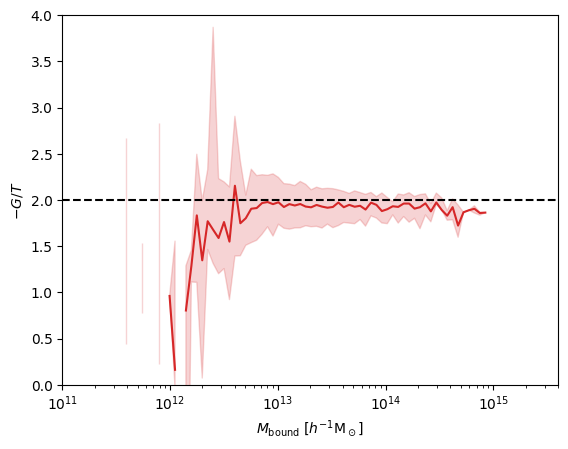

In [9]:
# Distribution of virial ratios as a function of mass

cond = halo_mboost > 0
median_M, bin_edges, bin_number = binned_statistic(halo_mboost[cond], G_T[cond], statistic = 'median', bins = np.geomspace(1e10,1e15, 100))

up_M = np.zeros(median_M.size)
low_M = np.zeros(median_M.size)
for i in range(median_M.size):
    cond_bin = (halo_mboost[cond] >= bin_edges[i]) & (halo_mboost[cond] < bin_edges[i+1])
    if halo_mboost[cond][cond_bin].size == 0:
        up_M[i], low_M[i] = (np.nan, np.nan)
        continue
    up_M[i], low_M[i] = np.percentile(G_T[cond][cond_bin], [97.5, 2.5])
    up_M[i], low_M[i] = np.percentile(G_T[cond][cond_bin], [84, 16])
    
bin_cent = 0.5*(bin_edges[1:] + bin_edges[:-1])

colour = "tab:red"#mpl.colormaps["RdPu"]((k + 2)/6)
plt.plot(bin_cent, median_M, color=colour, label = rf'$z = {np.round(header["Redshift"],decimals = 1)}$')
plt.fill_between(bin_cent, low_M, up_M, color=colour, alpha = 0.2)

plt.xscale('log')
#plt.yscale('log')
plt.xlabel(r"$M_{\rm bound}\ [h^{-1}{\rm M}_\odot]$")
plt.ylabel(r"$-G/T$")
#plt.axvlines(100*sim.header["ParticleMass"]*1e10, ymin = y_cent.min(), ymax = y_cent.max(), ls = '--', color = 'k')
plt.axhline(2, color = 'k', ls = '--')
plt.xlim(1e11, 4e15)
plt.ylim(0, 4)

Text(0, 0.5, '${\\rm d}n/{\\rm d}\\ln M_{\\rm bound}$')

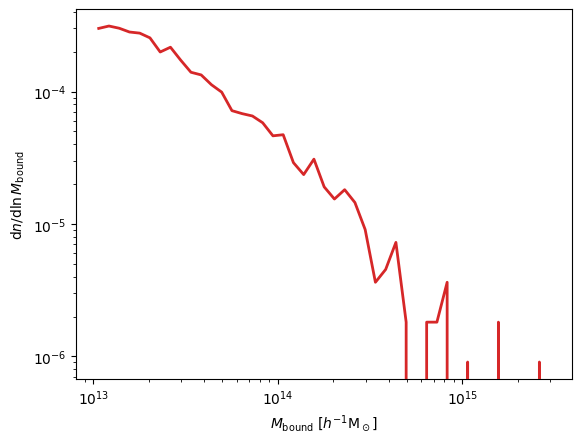

In [10]:
# Bound halo mass function

dN_boost, bins = np.histogram(halo_mboost, bins = np.logspace(10,15.5,100))

bin_cents = .5 *(bins[1:] + bins[:-1])
V_tot = header['BoxSize']**3
dlnM = np.diff(np.log(bins))
dn_dlnM_boost = dN_boost/V_tot/dlnM

colour = "tab:red"
cond  = bin_cents > 50*header["ParticleMass"]
plt.plot(bin_cents[cond], dn_dlnM_boost[cond], c = colour, lw =2, zorder = 10)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$M_{\rm bound}\ [h^{-1}{\rm M}_\odot]$")
plt.ylabel(r"${\rm d}n/{\rm d}\ln M_{\rm bound}$")

In [11]:
def radially_bin_percentile(r_bins, r, values, percentiles):
    '''
    Function stacking profiles and returning the percentiles in each of r_bins.

    Parameters:
    ------------
    r_bins: (Array of floats) radial bins within which to compute percentiles
    r: (array of floats) Radial positions of individual profiles
    values: (Array of floats) Weights to be binned
    percentiles: (list of floats) Percentiles to be returned

    Outputs:
    ------------
    res: (List of Arrays of float) radially bined percentiles
    '''
    n_per = np.array(percentiles).size
    res = np.zeros((len(r_bins), n_per))
    val_cond = np.isfinite(values)
    for k in range(len(r_bins)):
        if k == 0:
            cond = (r<=r_bins[0]) & val_cond
        cond = (r > r_bins[k-1]) & (r <= r_bins[k]) & val_cond
        if np.any(cond):
            res[k,:] = np.percentile(values[cond], percentiles)
        else: res[k, :] = [np.nan,] * n_per 
    if n_per == 1: res = res.reshape(-1)
    return res

Text(0, 0.5, '$r^2\\rho(r)/\\rho_{\\rm m}(z = 0)\\ [h^{-2}{\\rm Mpc}^2]$')

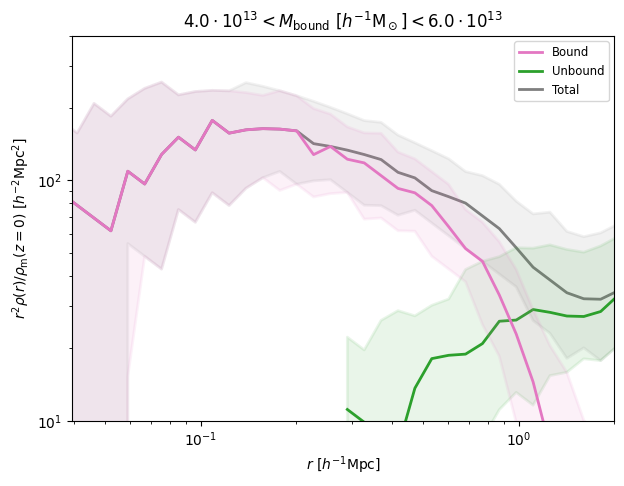

In [13]:
# Stacked profiles

fig, ax = plt.subplots(1,1, figsize = (7,5))

grav_const = 4.3009173e-9
H0 = header["HubbleParam"]*100
rho_c = 3*H0**2/(8*np.pi*grav_const)
rho_m = rho_c*header["Omega"]*header["Time"]**3

mass_cond = (halo_mboost > 4e13) & (halo_mboost < 6e13)
res_lim = np.mean(6*header['Softening'])

r_vals = (np.repeat(r_bins.reshape(-1,1), profiles_in[mass_cond].shape[0], axis = -1)).T 
med = np.zeros(profiles_in.shape[1])
high = np.zeros(profiles_in.shape[1])
low = np.zeros(profiles_in.shape[1])

res = radially_bin_percentile(r_bins, r_vals.flatten(), (r_vals**2*profiles_in[mass_cond]).flatten(), [16,50,84])

low = res[:,0]; med = res[:,1]; high = res[:,2]
colour = "tab:pink"
ax.plot(r_bins,med/rho_m, c = colour, lw = 2, ls = '-', label = "Bound")
ax.fill_between(r_bins,low/rho_m, high/rho_m, color = colour, lw = 2, ls = '-', alpha = 0.1)

med = np.zeros(profiles_in.shape[1])
high = np.zeros(profiles_in.shape[1])
low = np.zeros(profiles_in.shape[1])

res = radially_bin_percentile(r_bins, r_vals.flatten(), (r_vals**2 * (profiles_all-profiles_in)[mass_cond]).flatten(), [16,50,84])

low = res[:,0]; med = res[:,1]; high = res[:,2]

# inf_mass corresponds to the infalling mass, here fo visibility we do no show bins containing less than 10 particles
inf_mass = np.zeros(r_bins.shape)
inf_mass[r_bins > res_lim] = cumulative_trapezoid(x = r_bins[r_bins > res_lim], 
                                                  y = 4*np.pi * med[r_bins > res_lim]*rho_m, # med = <r^2rho / rho_m>
                                                  initial = 0)/header["ParticleMass"] 

colour = "tab:green"
ax.plot(r_bins[inf_mass > 10], med[inf_mass > 10]/rho_m, c = colour, lw = 2, ls = '-', zorder = -5, label = "Unbound")
ax.fill_between(r_bins[inf_mass > 10], low[inf_mass > 10]/rho_m, high[inf_mass > 10]/rho_m, color = colour, lw = 2, ls = '-', alpha = 0.1, zorder = -5)

med = np.zeros(profiles_in.shape[1])
high = np.zeros(profiles_in.shape[1])
low = np.zeros(profiles_in.shape[1])

res = radially_bin_percentile(r_bins, r_vals.flatten(), (r_vals**2 * (profiles_all)[mass_cond]).flatten(), [16,50,84])

low = res[:,0]; med = res[:,1]; high = res[:,2]

colour = "tab:grey"
ax.plot(r_bins, med/rho_m, c = colour, lw = 2, ls = '-', zorder = -10, label = "Total")
ax.fill_between(r_bins, low/rho_m, high/rho_m, color = colour, lw = 2, ls = '-', alpha = 0.1, zorder = -10)

exp_min = np.floor(np.log10(np.min((halo_mboost[mass_cond]))))
dec_min = np.min((halo_mboost[mass_cond]))/10**exp_min

exp_max = np.floor(np.log10(np.max((halo_mboost[mass_cond]))))
dec_max = np.max((halo_mboost[mass_cond]))/10**exp_max

ax.set_title(fr"${dec_min:.1f}\cdot 10^{{{int(exp_min):d}}} < M_{{\rm bound}}\ [h^{{-1}}{{\rm M}}_\odot] < {dec_max:.1f}\cdot 10^{{{int(exp_max):d}}}$")

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e1,4e2)
ax.set_xlim(res_lim, 2)
plt.legend(fontsize = 'small')
plt.xlabel(r"$r\ [h^{-1}{\rm Mpc}]$")

plt.ylabel(r"$r^2\rho(r)/\rho_{\rm m}(z = 0)\ [h^{-2}{\rm Mpc}^2]$")
